# <u>Clustering Assignment</u>
-  Kaustav Bhattacharjee

###  <i><u>Busyness Problem</u></i> -  categorise the countries using the given socio-economic and health factors that determine the overall development of the country. Then suggest the countries which needs most attention.



In [1]:
# Importing Required Libraries

import os
import pandas as pd
import numpy as np
pd.set_option("max_columns", None) 
pd.set_option("max_rows", 20) 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the data

df_actual = pd.read_csv('Country-data.csv')
df = df_actual.copy()
df1 = df_actual.copy()
df2 = df_actual.copy()
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## 1.1 Basic analysis of the data

In [3]:
# Checking the basic informations about the columns of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


- from the above information we can see that the columns do not need any data type change.

In [4]:
# Checking the count of missing values in all the columns

df.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

- From the above information we can see that there is no missing data in the dataset.

In [5]:
# Checking the description of the data frame

df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


- <b>As per the given data, 'exports', 'health' and 'imports' are dependent upon the 'gdpp' column, to get more sense out of these columns, these columns will be converted into absolute values from percentage value which is based on the GDP of the Country.<b>

In [6]:
# Checking the data frame after converting 'exports', 'health' and 'imports' to absolute value

for i in ['exports', 'health', 'imports']:
    df[i] = (df[i]*df.gdpp)/100
    
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## 1.2 Checking the distributions fro each of the numeric columns using a box plot to check if outlier treatment is required

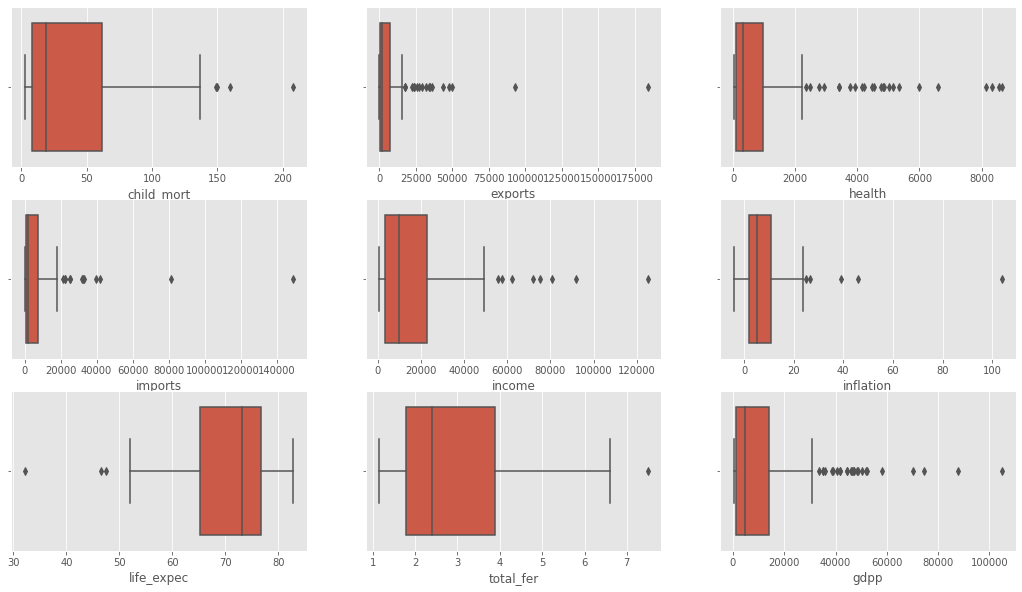

In [7]:
# checking distribuions of certain columns

plt.style.use('ggplot')
plt.figure(figsize=[18,10])
for i in df.drop(['country'], axis=1).columns.tolist():
    plt.subplot(3,3,df.columns.get_loc(i))
    sns.boxplot(x=df[i])
    plt.xlabel(i)
plt.show()

- <b>From the above box and whisker plot, we can see that there are outliers which might impact our analysis, hence, the outliers needs to be handled before going forward with the analysis.</b>


- <b>As our objective is to find out the countries with urgent need of aid, we can cap the variables in such a way that countries with a higher 'exports' value, 'health' conditions, 'imports' value, 'income', and 'gdpp' are capped in such a way that the high values from these variables doesn't effect our analysis. And for the variables, 'child_mort' and 'inflation', there are no outliers in the lower range which could actually have unwanted effect on our analysis, so, we do not need to perform any outliers treatment fore these two variable.</b>

### 2.1 Preprocessing the data to handle outliers

In [8]:
# Caping outliers as described above

for i in df.drop(['country', 'child_mort', 'inflation', 'total_fer'], axis=1).columns.tolist():
    df[i] = df[i].apply(lambda x : x if x <= round(df[i].quantile(0.99),2) else round(df[i].quantile(0.99),2))

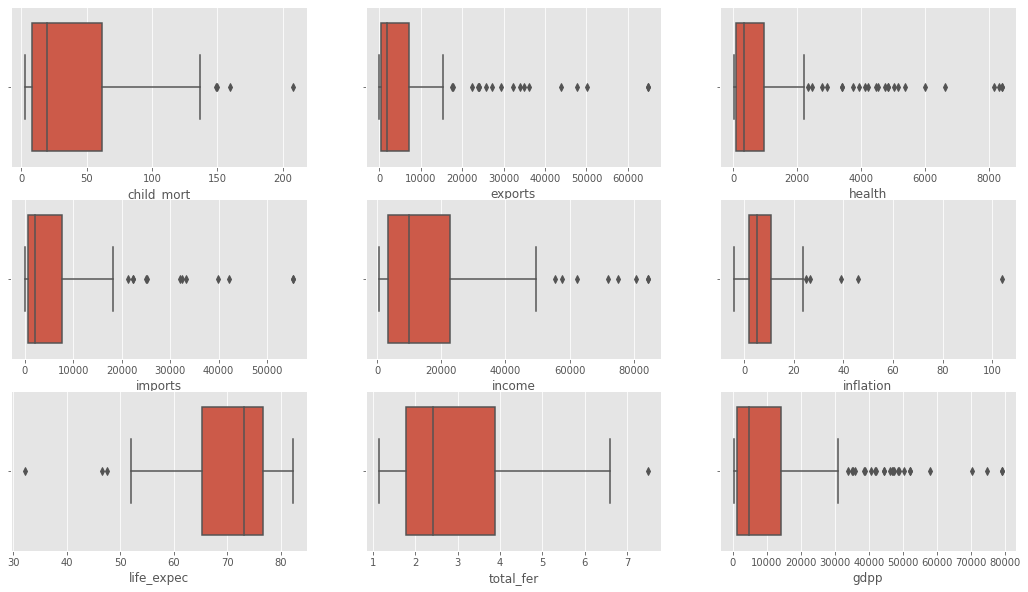

In [9]:
#Checking the distributions for each of the numeric columns using a box plot after capping outliers at 99 percentile

plt.style.use('ggplot')
plt.figure(figsize=[18,10])
for i in df.drop(['country'], axis=1).columns.tolist():
    plt.subplot(3,3,df.columns.get_loc(i))
    sns.boxplot(x=df[i])
    plt.xlabel(i)
plt.show()

### 2.2 Standardizing the columns to get all the columns in same scale

In [10]:
# initializing Standard Scaler and transforming the datset using the 'sc' object

sc = StandardScaler()
df_sc = df.drop(['country'], axis=1)
for i in df_sc.columns.tolist():
    df_sc[i] = sc.fit_transform(df_sc[[i]])
    
df_sc.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.569622,-0.566958,-0.598741,-0.851668,0.157336,-1.619705,1.902882,-0.702259
1,-0.538949,-0.473858,-0.440393,-0.413584,-0.386946,-0.312347,0.648831,-0.859973,-0.498726
2,-0.272833,-0.424000,-0.486271,-0.476100,-0.221053,0.789274,0.671403,-0.038404,-0.477434
3,2.007808,-0.381249,-0.534088,-0.463973,-0.612045,1.387054,-1.179541,2.128151,-0.530950
4,-0.695634,-0.086742,-0.178410,0.139728,0.125254,-0.601749,0.705262,-0.541946,-0.032042


## Hopkins Statistics:
The Hopkins statistic gives a value which indicates how well the data can be clustered.

In [11]:
def hopkins(X):
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return round(H,3)

In [12]:
# Running Hopkins Statistics for 10 times and taking the average of it

h=[]
for i in range(0,10):
    h.append(hopkins(df_sc))
round(sum(h)/len(h),3)

0.898

- <b>The above value of Hopkins Statistics Tels us that this data set is a got fit for clustering</b>

### 3.1 Finding out the number of clusters

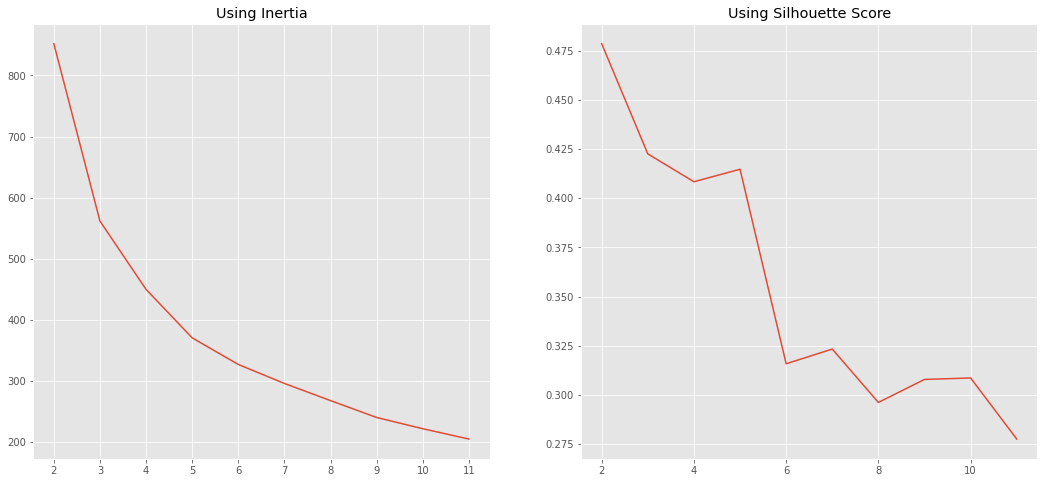

In [13]:
# Using inertia

ssd = []
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
for num in clusters:
    kmeans = KMeans(n_clusters=num, random_state = 100)
    kmeans.fit(df_sc)
    ssd.append(kmeans.inertia_)

plt.figure(figsize=[18,8])
plt.subplot(1,2,1)
plt.plot(ssd)
plt.title('Using Inertia')
plt.xticks(ticks = [0,1, 2, 3, 4, 5, 6, 7, 8, 9], labels = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])

# Using silhoutte_scor
ss = []
for k in range(2,12):
    kmeans = KMeans(n_clusters=k, random_state = 100).fit(df_sc)
    ss.append([k, silhouette_score(df_sc, kmeans.labels_)])
ss = pd.DataFrame(ss)

plt.subplot(1,2,2)
plt.plot(ss[0], ss[1])
plt.title('Using Silhouette Score')
plt.show()

- <b>From the above charts, we can see that going with <u><i>K = 3</i></u> clusters would be a good option for us for this dataset.</b>

### 3.2 Clustering the dataset using the value of K = 3 (Using KMeans Clustering)

In [14]:
# Initializing K Means and fitting the scaled data

kmeans = KMeans(n_clusters=3, random_state = 100)
kmeans.fit(df_sc)

KMeans(n_clusters=3, random_state=100)

In [15]:
# getting the cluster labels and adding them to the dataset

cluster_label = kmeans.labels_
df['cluster_label'] = cluster_label
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2


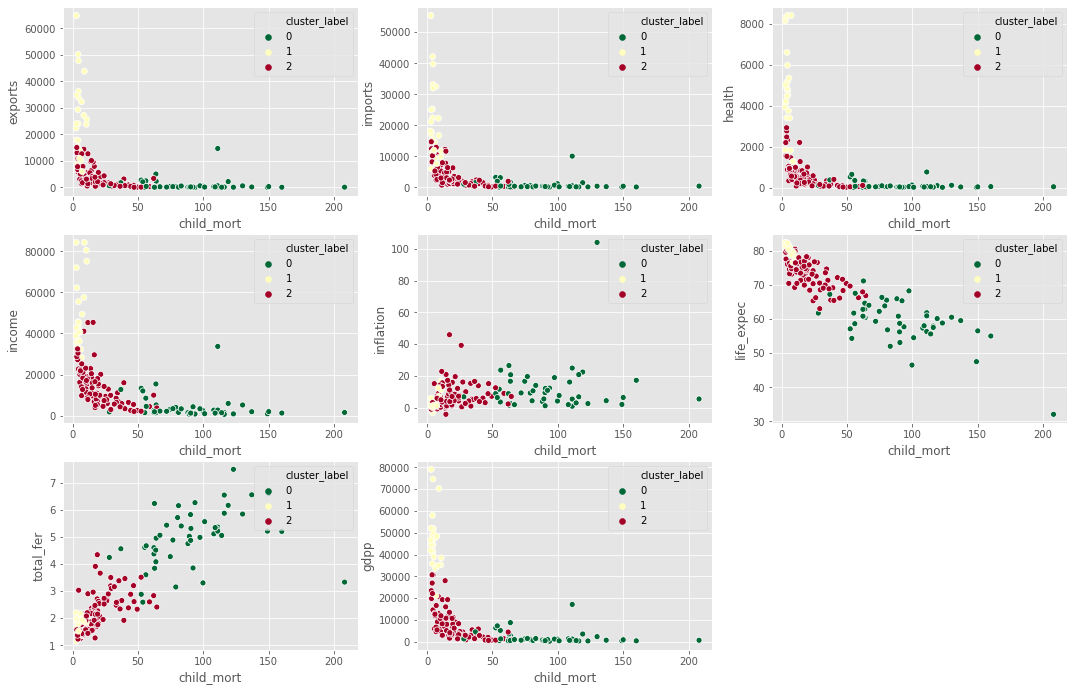

In [16]:
# Ploting the data based on clusters

plt.figure(figsize=[18,16])
plt.subplot(4,3,1)
sns.scatterplot(data= df, x = 'child_mort', y = 'exports', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,2)
sns.scatterplot(data= df, x = 'child_mort', y = 'imports', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,3)
sns.scatterplot(data= df, x = 'child_mort', y = 'health', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,4)
sns.scatterplot(data= df, x = 'child_mort', y = 'income', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,5)
sns.scatterplot(data= df, x = 'child_mort', y = 'inflation', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,6)
sns.scatterplot(data= df, x = 'child_mort', y = 'life_expec', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,7)
sns.scatterplot(data= df, x = 'child_mort', y = 'total_fer', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,8)
sns.scatterplot(data= df, x = 'child_mort', y = 'gdpp', hue = 'cluster_label', palette='RdYlGn_r')
plt.show()

- <b>From the above scatter plots we can clearly see that cluster <u><i>K=0</i></u> has the similar Countries which are in more need of aid than that of Countries in the other two clusters.</b>

In [17]:
# top Countries which are in most need of aid

top10Countries_KMeans = df[df.cluster_label == 0].sort_values(by = ['child_mort', 'gdpp','health', 'imports'], 
                                      ascending =[False, True, True, True]).iloc[:10,0].to_list()

### 3.3 Applying Hierarchical Clustering Using Single Linkage

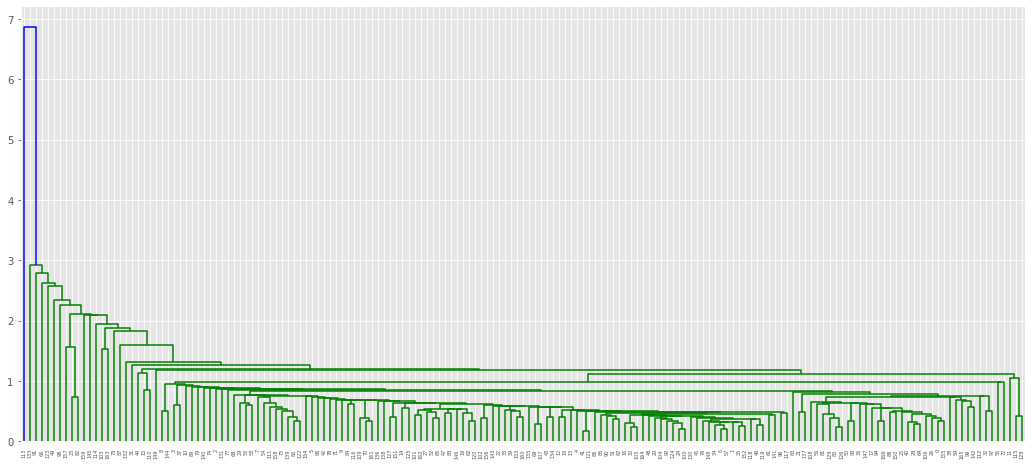

In [18]:
# Making the dendrogram to create the clusters

plt.figure(figsize=[18,8])
mergings = linkage(df_sc, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

In [19]:
# getting the cluster labels and adding them to the dataset

cluster_label_1 = cut_tree(mergings, n_clusters=3).reshape(-1, )
df1['cluster_label'] = cluster_label_1
df1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


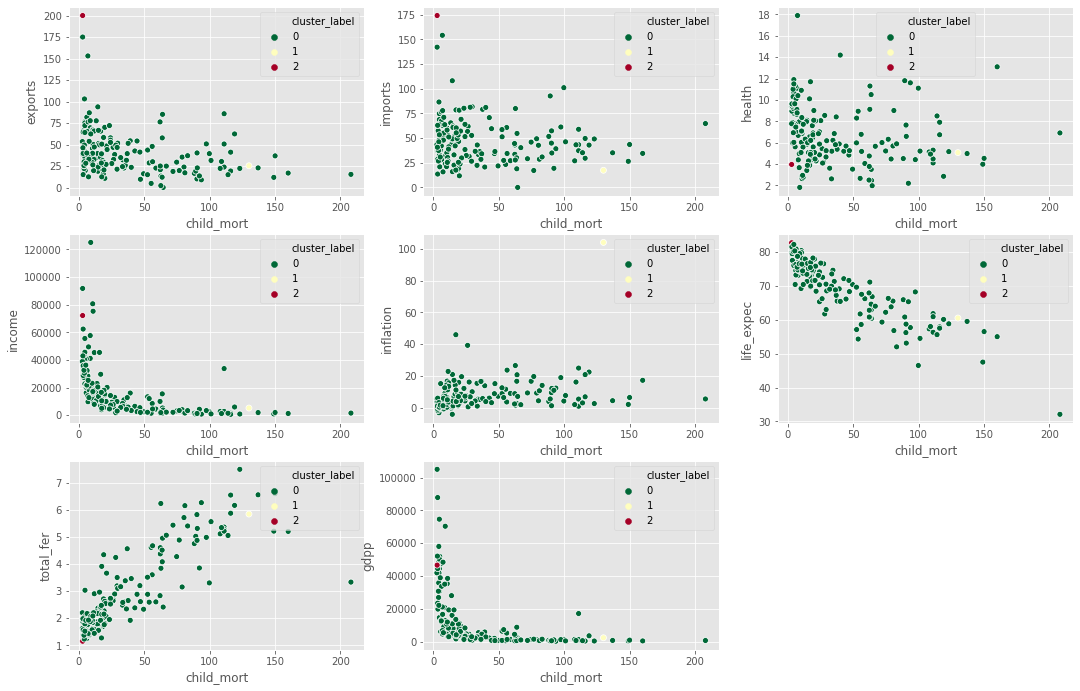

In [20]:
# Ploting the data based on clusters

plt.figure(figsize=[18,16])
plt.subplot(4,3,1)
sns.scatterplot(data= df1, x = 'child_mort', y = 'exports', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,2)
sns.scatterplot(data= df1, x = 'child_mort', y = 'imports', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,3)
sns.scatterplot(data= df1, x = 'child_mort', y = 'health', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,4)
sns.scatterplot(data= df1, x = 'child_mort', y = 'income', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,5)
sns.scatterplot(data= df1, x = 'child_mort', y = 'inflation', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,6)
sns.scatterplot(data= df1, x = 'child_mort', y = 'life_expec', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,7)
sns.scatterplot(data= df1, x = 'child_mort', y = 'total_fer', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,8)
sns.scatterplot(data= df1, x = 'child_mort', y = 'gdpp', hue = 'cluster_label', palette='RdYlGn_r')
plt.show()

- <b>From the above scatter plots we can clearly see that cluster <u><i>K=0</i></u> has the similar Countries which are in more need of aid than that of Countries in the other two clusters.</b>

In [21]:
# top Countries which are in most need of aid based on Hierarchical Clustering's Single Linkage Method

top10Countries_HC_Single = df1[df1.cluster_label == 0].sort_values(by = ['child_mort', 'gdpp','health', 'imports'], 
                                      ascending =[False, True, True, True]).iloc[:10,0].to_list()

### 3.4 Applying Hierarchical Clustering Using complete Linkage

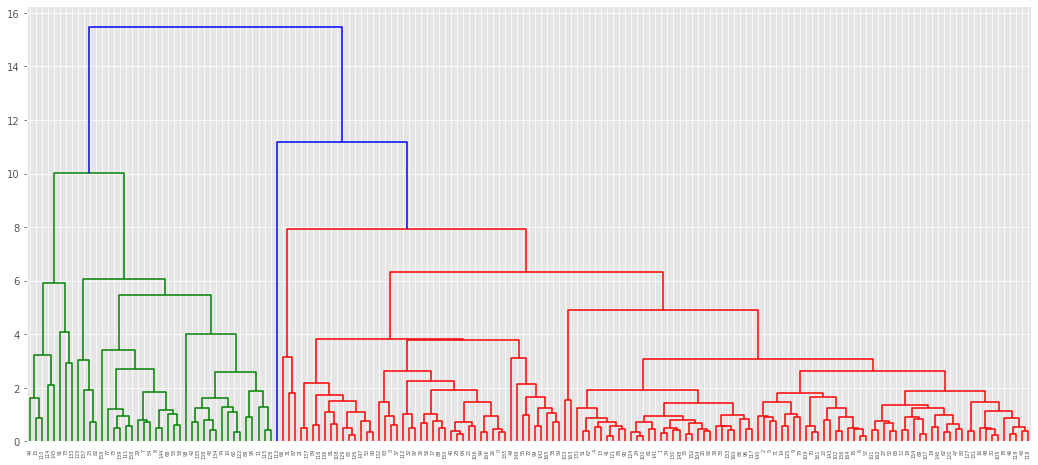

In [22]:
# Making the dendrogram to create the clusters

plt.figure(figsize=[18,8])
mergings = linkage(df_sc, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [23]:
# getting the cluster labels and adding them to the dataset

cluster_label_2 = cut_tree(mergings, n_clusters=3).reshape(-1, )
df2['cluster_label'] = cluster_label_2
df2.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_label
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


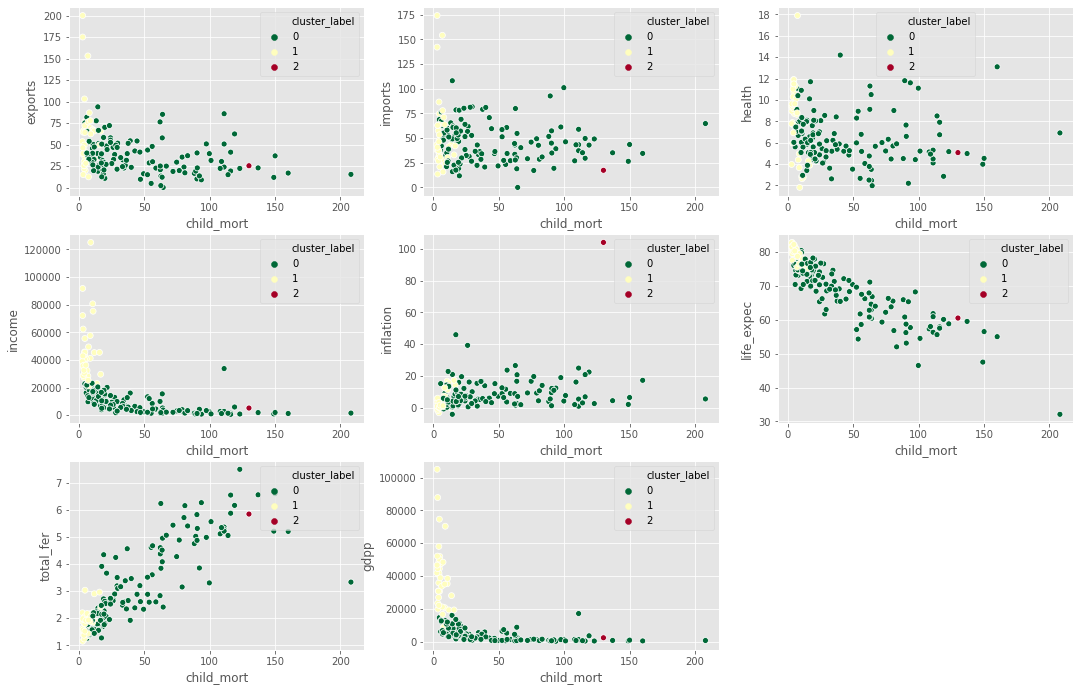

In [24]:
# Ploting the data based on clusters

plt.figure(figsize=[18,16])
plt.subplot(4,3,1)
sns.scatterplot(data= df2, x = 'child_mort', y = 'exports', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,2)
sns.scatterplot(data= df2, x = 'child_mort', y = 'imports', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,3)
sns.scatterplot(data= df2, x = 'child_mort', y = 'health', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,4)
sns.scatterplot(data= df2, x = 'child_mort', y = 'income', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,5)
sns.scatterplot(data= df2, x = 'child_mort', y = 'inflation', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,6)
sns.scatterplot(data= df2, x = 'child_mort', y = 'life_expec', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,7)
sns.scatterplot(data= df2, x = 'child_mort', y = 'total_fer', hue = 'cluster_label', palette='RdYlGn_r')
plt.subplot(4,3,8)
sns.scatterplot(data= df2, x = 'child_mort', y = 'gdpp', hue = 'cluster_label', palette='RdYlGn_r')
plt.show()

- <b>From the above scatter plots we can clearly see that cluster <u><i>K=0</i></u> has the similar Countries which are in more need of aid than that of Countries in the other two clusters.</b>

In [25]:
# top Countries which are in most need of aid based on Hierarchical Clustering's Complete Linkage Method

top10Countries_HC_Complete = df2[df2.cluster_label == 0].sort_values(by = ['child_mort', 'gdpp','health', 'imports'], 
                                      ascending =[False, True, True, True]).iloc[:10,0].to_list()

### 4.1 List of top Countries combined from all methods

In [26]:
final_country_list = top10Countries_HC_Complete+top10Countries_HC_Single+top10Countries_HC_Complete
final_country_list = sorted(list(set(final_country_list)))

### The top 10 Countries which are in need of Aid :
<br>

 <b>
    1. Angola <br>
    2. Burkina Faso <br>
    3. Central African Republic <br>
    4. Chad <br>
    5. Congo-Dem.Rep. <br>
    6. Guinea-Bissau <br>
    7. Haiti <br>
    8. Mali <br>
    9. Niger <br>
   10. Sierra Leone.
</b>